In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [3]:
df = pd.read_csv("insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
df.describe(include="all")

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


In [8]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [10]:
df_encoded = df.copy()
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in ['sex','smoker','region']:
    df_encoded[col] = le.fit_transform(df_encoded[col])

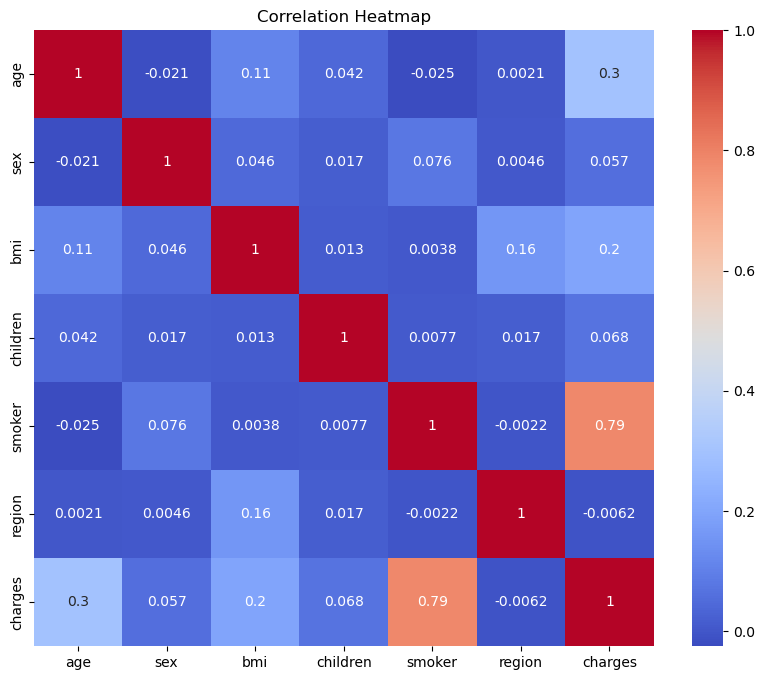

In [11]:
plt.figure(figsize=(10,8))
sns.heatmap(df_encoded.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

You will see a very high number (0.79) for Smoker. This tells you 
that "Smoking" is the biggest predictor of insurance cost. 

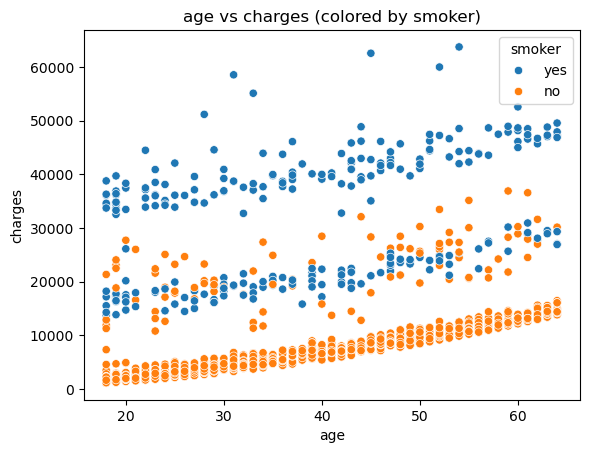

In [14]:
sns.scatterplot(x='age', y='charges', hue='smoker', data = df)
plt.title('age vs charges (colored by smoker)')
plt.show()

You will notice three distinct "lines" or layers of data.

Bottom line: Non-smokers (lowest costs).

Middle line: Smokers with healthy BMI.

Top line: Smokers with high BMI. This tells you that a simple line might not fit perfectly—you might need to help the model later by "scaling" or "engineering" features.

In [22]:
df_final=pd.get_dummies(df, drop_first=True)
X=df_final.drop('charges', axis=1)
y=df_final['charges']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print(f'training rows: {len(X_train)}')
print(f'testing rows: {len(X_test)}')

training rows: 1070
testing rows: 268


In [24]:
# Train model
lr=LinearRegression()
lr_model = lr.fit(X_train,y_train)
y_pred=lr_model.predict(X_test)

we use three specific methods to "audit" our model's predictions.

In [34]:
# Side-by-Side Comparison (The Truth Table)

comparison_df=pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
comparison_df['Residual'] = comparison_df['Actual'] - comparison_df['Predicted']
comparison_df.head(10)

,Actual,Predicted,Residual
764,9095.06825,8969.550274,125.517976
887,5272.17580,7068.747443,-1796.571643
890,29330.98315,36858.410912,-7527.427762
1293,9301.89355,9454.678501,-152.784951
259,33750.29180,26973.173457,6777.118343
1312,4536.25900,10864.113164,-6327.854164
899,2117.33885,170.280841,1947.058009
752,14210.53595,16903.450287,-2692.914337
1286,3732.62510,1092.430936,2640.194164
707,10264.44210,11218.343184,-953.901084


Looking at these 10 rows, your errors are quite varied (ranging from $125 to $7,500).

The Verdict: Your model has "learned" the general trend, but it is struggling with the high-cost cases. This is very common with Simple Linear Regression because it tries to fit a perfectly straight line through data that might be slightly "curved."

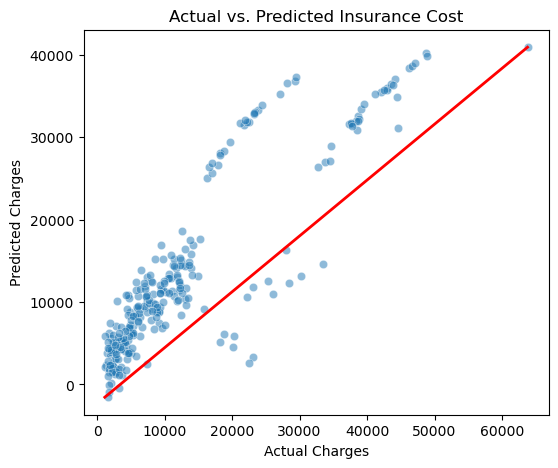

In [35]:
# The Actual vs. Predicted Plot (The "45-Degree" Test)

plt.figure(figsize=(6,5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], color='red', lw=2)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs. Predicted Insurance Cost')
plt.show()

This graph reveals three specific things about your model:

Under-prediction: Look at the dots on the far right that are below the red line. These are people with very high actual costs (around $40k–$60k) that your model predicted would only cost $30k–$40k.

Business Impact: The insurance company would lose money on these customers.

Over-prediction: Look at the dots above the red line. Your model predicted higher costs than what actually occurred.

Business Impact: You might lose these customers to competitors because your quoted price is too high.

Non-Linearity: Notice how the dots seem to form three separate "clumps" or lines? This confirms what we saw in the EDA phase: insurance data isn't one single straight line. It is divided by categories like Smoker vs. Non-Smoker.

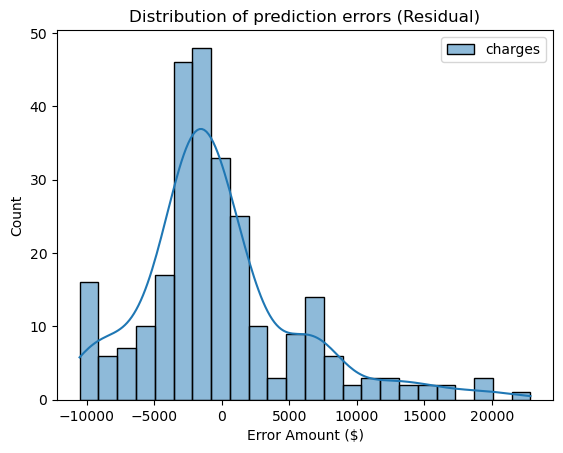

In [37]:
sns.histplot([y_test-y_pred], kde=True)
plt.title('Distribution of prediction errors (Residual)')
plt.xlabel('Error Amount ($)')
plt.show()

It has a bell shape, which is a great start! This means that for most people, the model's errors are small and predictable.

peak is slightly to the left (around -2,000).

What it means: Since Residual = Actual - Prediced, a negative number means Predicted was higher.

Business Insight: Our model has a slight tendency to over-price the insurance premiums for the average person. In real life, this is "safe" for the insurance company (they collect more money), but they might lose customers to cheaper competitors.

Look at the bars stretching out to $10,000 and $20,000 on the right side.

The Cause: These are likely the high-risk smokers or obese patients we saw earlier. The Linear model "undershot" their costs because a straight line couldn't curve upward fast enough to catch them.

Business Impact: These specific "tail" cases are where the insurance company would lose a lot of money.

In [41]:
from sklearn.metrics import r2_score, mean_absolute_error
print(f'R2_score: {r2_score(y_test,y_pred):.4f}')
print(f'Average error: ${mean_absolute_error(y_test,y_pred):.2f}')

R2_score: 0.7836
Average error: $4181.19


In [48]:
def predict_insurance_cost(age,bmi,children,sex,smoker,region):
    input_data={
        'age': age,
    'bmi': bmi,
    'children': children,
    'sex': sex,
    'smoker' : smoker,
    'region': region
    }

    input_df=pd.DataFrame([input_data])
    input_encoded=pd.get_dummies(input_df)
    input_final=input_encoded.reindex(columns=X.columns, fill_value=0)

    prediction = lr_model.predict(input_final)

    return prediction[0]

insurance_cost = predict_insurance_cost(age=25, bmi=24.5, children=0, smoker='yes', sex='male', region='southeast')
print(f'Insurance cost is: ${insurance_cost:.2f}')
    

Insurance cost is: $25726.61


In [58]:
print("Give your details:\n")
age = int(input("Age:"))
bmi = float(input("BMI (Body Mass Indes):"))
children = int(input("Children count:"))
smoker = input("Smoker (yes/no):").lower()
sex = input("sex (male/female):").lower()
region = input("Enter Region (northeast/northwest/southeast/southwest): ").lower()

insurance_cost = predict_insurance_cost(age, bmi, children, smoker, sex, region)
print(f'Your Insurance Cost is: ${insurance_cost:.2f}')


Give your details:



Age: 45
BMI (Body Mass Indes): 30
Children count: 3
Smoker (yes/no): no
sex (male/female): male
Enter Region (northeast/northwest/southeast/southwest):  southeast


Your Insurance Cost is: $10363.44
